In [31]:
import numpy as np
import pandas as pd


In [32]:
import matplotlib.pyplot as plt

#from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [33]:
train = pd.read_csv(r'C:\Users\Shibbs\Desktop\Projects\Sentiment analysis\My notebooks\5emotions_final_processed.csv')

In [34]:
train = train.drop(columns = ['Unnamed: 0'])

In [35]:
train.head()

,labels,tweet
0,neutral,we want to trade with someone who has houston...
1,worry,repinging why didnt you go to prom bc my bf d...
2,worry,hmmm is down
3,sadness,charlene my love i miss you
4,sadness,im sorry at least its friday


In [36]:
train.to_csv('5emotions_final_processed_v2.csv')

In [37]:
embeddings_index = {}

f = open(r'C:\Users\Shibbs\Desktop\Projects\Sentiment analysis\My dataset\glove.twitter.27B.200d.txt', encoding="utf8")

for line in f:

    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [38]:
import re
train.tweet=train.tweet.astype(str)
## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in train['tweet'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

print(texts[0:1])

[['want', 'trade', 'someone', 'houston', 'tickets', 'one']]


In [123]:
len(max(texts))

19

In [124]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

MAX_NUM_WORDS = 30000
MAX_SEQUENCE_LENGTH = len(max(texts))
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')

labels = pd.get_dummies(train['labels']).values
print(data.shape)
print(labels.shape)

Found 21469 unique tokens.
(19955, 19)
(19955, 5)


In [125]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size= 0.20)

In [126]:
from keras.layers import Embedding
from keras.initializers import Constant

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(21470, 200)


Text(0.5, 1.0, 'virus')

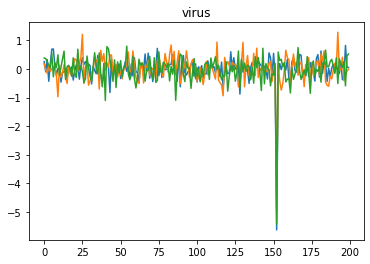

In [127]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('virus')

In [255]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, GRU, Conv1D, MaxPooling1D, Dropout, SpatialDropout1D, Activation

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH, weights = [embedding_matrix], trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(200))

model.add(Dense(5, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, 19, 200)           4294000   
_________________________________________________________________
dropout_29 (Dropout)         (None, 19, 200)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 15, 64)            64064     
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 200)               212000    
_________________________________________________________________
dense_52 (Dense)             (None, 5)                 1005      
Total params: 4,571,069
Trainable params: 277,069
Non-trainable params: 4,294,000
_____________________________________

In [256]:
epochs = 100
batch_size = 32

history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size,callbacks=[
                    EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 15964 samples, validate on 3991 samples
Epoch 1/100
15964/15964 [==============================] - 9s 559us/step - loss: 0.4723 - accuracy: 0.8023 - val_loss: 0.4614 - val_accuracy: 0.8034
Epoch 2/100
15964/15964 [==============================] - 8s 521us/step - loss: 0.4525 - accuracy: 0.8064 - val_loss: 0.4614 - val_accuracy: 0.8047
Epoch 3/100
15964/15964 [==============================] - 8s 514us/step - loss: 0.4386 - accuracy: 0.8102 - val_loss: 0.4644 - val_accuracy: 0.8038
Epoch 4/100
15964/15964 [==============================] - 8s 518us/step - loss: 0.4210 - accuracy: 0.8185 - val_loss: 0.4741 - val_accuracy: 0.7998


In [257]:
df0 = pd.read_csv(r'C:\Users\Shibbs\Desktop\Projects\Sentiment analysis\My dataset\mumbai_cleaned_new.csv')

In [258]:
def prediction(dataframe):
    
    list1 = []
    list2 = []
    preds = []

    for index,row in dataframe.iterrows():
        desc = row['tweet']
        list1.append(desc)
        
    for i in list1:
        
        list1 = pad_sequences(tokenizer.texts_to_sequences([i]), truncating='post',maxlen=MAX_SEQUENCE_LENGTH)
        score = model.predict([list1])
        preds.append(score)
        emotions = np.array(preds)
        
    for i in range(0, len(emotions)):
        if np.argmax(emotions[i][0]) == 0:
            list2.append('happiness')
        elif np.argmax(emotions[i][0]) == 1:
            list2.append('joy')
        elif np.argmax(emotions[i][0]) == 2:
            list2.append('neutral')
        elif np.argmax(emotions[i][0]) == 3:  
            list2.append('sadness')
        elif np.argmax(emotions[i][0]) == 4:
            list2.append('worry')
        
    
    return list2

In [259]:
sentiments = prediction(df0)

In [260]:
df0['sentiment'] = sentiments

In [261]:
df0['sentiment'].value_counts()

neutral      176
sadness       70
worry         58
happiness     37
joy           17
Name: sentiment, dtype: int64

In [262]:
index = 49

print(df0['tweet'][index])
print(df0['sentiment'][index])

mumbai coronavirus updates missionbeginagain unlock suspected positive total positive patients deaths discharged today deaths in the city since recovery rate tests till june tests on th
worry


In [264]:
df0.to_csv(r'C:\Users\Shibbs\Desktop\Projects\Sentiment analysis\My dataset\glove_cnn_lstm2_7.2.csv')

In [263]:
model.save('glove_cnn_lstm_gpu2_7.2.h5')

In [170]:
df1 =  pd.read_csv(r'C:\Users\Shibbs\Desktop\Projects\Sentiment analysis\My dataset\glove_cnn_lstm2_7.1.csv')

In [173]:
df1['sentiment'].value_counts()

neutral      189
worry         73
sadness       52
happiness     26
joy           18
Name: sentiment, dtype: int64

In [222]:
for index, row in df0.iterrows():
    if df0['sentiment'][index] == 'joy':
        print(df0['tweet'][index])
        

the way i love myself do u also love me love care hope together beauty unlock sobo mumbai india anahitakapoor
quarantine ward life of gujjus gujjus can be happy anywhere retweet quarantinetimepass unlock unlock gujarat maharashtra lockdown bangalore coimbatore indianairforce karachi katrinakaif mumbairains mumbai sidnaaz upsc voguechallenge missyouyuvi
couldn t resist in sharing this forward unlock mumbaikars mumbai backtowork
don t be so badshah guys stay safe coronavirus unlock shahrukhkhan shahrukhkhanfan covid memesdaily bjp mumbai delhi narendermodi lockdownextension coronawarriors vaccine newshot shahrukh asksrk
friend kya hoga mumbai ka after unlock me
all those who ask me how s mumbai doing here s the answer we re preparing to flatten the curve together with unlock i guess we re doing it right right
what an idea sir ji this is how unlock looks like wonder what and would be just imagine when mumbai locals resume services
bless each mumbaikar mumbai travelling to work or shop tra